In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import tqdm
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import maptools
import constant as c
import cmb
# others
import local
import tools_cmb
import tools_multitracer as mass
import warnings
warnings.filterwarnings("ignore")

In [2]:
def compute_clfg(pobj,rlz,M,lmax,NSIDE=64,method=0):
    Q = hp.read_map(pobj.ffgs[rlz],field=1)/c.Tcmb
    U = hp.read_map(pobj.ffgs[rlz],field=2)/c.Tcmb
    Q = hp.ud_grade( Q, NSIDE )
    U = hp.ud_grade( U, NSIDE )
    if method == 0:
        Elm, Blm = cs.utils.hp_map2alm_spin(NSIDE,lmax,lmax,2,Q,U)
        QB, UB = cs.utils.hp_alm2map_spin(NSIDE,lmax,lmax,2,0*Elm,Blm)
        Elm, Blm = cs.utils.hp_map2alm_spin(NSIDE,lmax,lmax,2,M*QB,M*UB)
    if method == 1:
        Elm, Blm = cs.utils.hp_map2alm_spin(NSIDE,lmax,lmax,2,M*Q,M*U)
    return cs.utils.alm2cl(lmax,Blm)

In [3]:
# define parameters
lmax  = 190     # maximum multipole of alm to be generated
NSIDE = 128
l = np.linspace(0,lmax,lmax+1)
fac = l*(l+1)/2/np.pi*c.Tcmb**2
wl = hp.sphtfunc.pixwin(NSIDE,lmax=lmax)
bl = cmb.beam(80.,lmax)

### Read galaxy survey mask

In [5]:
M = hp.ud_grade(hp.read_map('../data/lensing/FG_mask.fits'),NSIDE)
W = cs.utils.apodize(NSIDE, M, 1.)
#W = M.copy()
W2 = np.mean(W**2)
print(W2)

0.46264096931410165


In [6]:
simn = 10
BB0 = np.zeros((simn,lmax+1))
BB1 = np.zeros((simn,lmax+1))
for rlz in tqdm.tqdm(range(1,simn+1)):
    BB0[rlz-1] = compute_clfg(pobj,rlz,W,lmax,NSIDE=NSIDE)
    BB1[rlz-1] = compute_clfg(pobj,rlz,W,lmax,NSIDE=NSIDE,method=1)
mBB0 = np.mean(BB0,axis=0)
mBB1 = np.mean(BB1,axis=0)

100%|██████████| 10/10 [00:01<00:00,  6.93it/s]


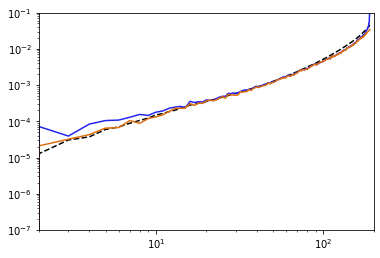

In [7]:
xlim(2,200)
ylim(1e-7,1e-1)
loglog(l,fac*pobj.clfg[:lmax+1],label='noise',color='k',ls='--')
loglog(l,fac*mBB0/W2/wl**2*bl**2)
loglog(l,fac*mBB1/W2/wl**2*bl**2)